# Dataset Exploration

## Imports and Load Data

In [14]:
import matplotlib.pyplot as plt
import fiftyone as fo
import os
import numpy as np
import PIL

In [15]:
DOWNLOAD_DIR = "/content/"
ZIP_FILE = "https://nx82872.your-storageshare.de/s/RSd8ee55qQsMSPb/download"
# !rm -f data.zip
# !wget -v $ZIP_FILE -O data.zip
# !rm -rf $DOWNLOAD_DIR/data
# !unzip data.zip -d $DOWNLOAD_DIR

In [16]:
DATA_DIR = "../../../NVIDIA Multimodal Models/code/data"
# DATA_DIR = f"{DOWNLOAD_DIR}data"
FO_DATASET_NAME = "cilp_assessment"
print(os.listdir(DATA_DIR))

['bridge.mp4', 'assessment.tar.xz', 'flower_photos.csv', 'cat_example-2.nii', 'assessment', 'replicator_data_parallel', 'replicator_data_orthogonal', 'warehouse.mp4', 'grace-blackwell-datasheet.pdf', 'flower_photos', 'cubes_only_single_mode_results.csv', 'replicator_data_cubes', 'assessment.zip', 'traffic.mp4', 'cat_example-1.wav']


## Create Grouped FO Dataset

Added 39996 samples to the dataset.
Dataset created: Name:        cilp_assessment
Media type:  group
Group slice: rgb
Num groups:  19998
Persistent:  False
Tags:        []
Sample fields:
    id:               fiftyone.core.fields.ObjectIdField
    filepath:         fiftyone.core.fields.StringField
    tags:             fiftyone.core.fields.ListField(fiftyone.core.fields.StringField)
    metadata:         fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.metadata.Metadata)
    created_at:       fiftyone.core.fields.DateTimeField
    last_modified_at: fiftyone.core.fields.DateTimeField
    group:            fiftyone.core.fields.EmbeddedDocumentField(fiftyone.core.groups.Group)
    object_type:      fiftyone.core.fields.StringField
    azimuth:          fiftyone.core.fields.ListField(fiftyone.core.fields.FloatField)
    zenith:           fiftyone.core.fields.ListField(fiftyone.core.fields.FloatField)
    slice_type:       fiftyone.core.fields.StringField
Total samples: 19998
Classe

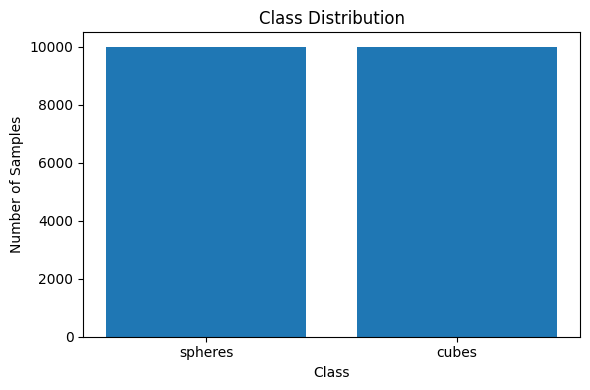

In [21]:
if FO_DATASET_NAME in fo.list_datasets():
    fo.delete_dataset(FO_DATASET_NAME)

dataset = fo.Dataset(FO_DATASET_NAME)
dataset.add_group_field("group", default="rgb")

def load_metadata(obj_dir):
    az = np.load(os.path.join(obj_dir, "azimuth.npy"))
    ze = np.load(os.path.join(obj_dir, "zenith.npy"))
    return az, ze

types = ["cubes", "spheres"]
slices = ["rgb", "lidar"]
count = 0
groups = {t: [] for t in types}

for obj_type in types:
    obj_root = os.path.join(DATA_DIR, "assessment", obj_type)
    azimuth, zenith = load_metadata(obj_root)

    # Create one group per sample index
    max_len = max(len(os.listdir(os.path.join(obj_root, s))) for s in slices)
    groups[obj_type] = [fo.Group() for _ in range(max_len)]

    for slice_name in slices:
        slice_dir = os.path.join(obj_root, slice_name)
        files = sorted([
            f for f in os.listdir(slice_dir)
            if f.endswith(".png") or f.endswith(".npy")
        ])
        
        for idx, fname in enumerate(files):
            fpath = os.path.join(slice_dir, fname)
            if fname.endswith(".npy"):
                # Load numpy array and convert to PIL Image for FiftyOne
                array = np.load(fpath)
                if array.ndim == 2:  # Grayscale
                    img = PIL.Image.fromarray((array * 255).astype(np.uint8), mode='L')
                else:  # RGB
                    img = PIL.Image.fromarray((array * 255).astype(np.uint8), mode='RGB')
                img_path = fpath.replace('.npy', '.png')
                img.save(img_path)
                fpath = img_path

            sample = fo.Sample(
                filepath=fpath,
                group=groups[obj_type][idx].element(slice_name),
                object_type=obj_type,
                azimuth=azimuth.tolist(),
                zenith=zenith.tolist(),
                slice_type=slice_name,
            )
            dataset.add_sample(sample)
            count += 1
print(f"Added {count} samples to the dataset.")

print("Dataset created:", dataset)
print("Total samples:", len(dataset))
print("Classes:", dataset.distinct("object_type"))
class_counts = dataset.count_values("object_type")
print("\nTotal samples per class:")
for cls, count in class_counts.items():
    print(f"  {cls}: {count}")

train_ratio = 0.8
train_view = dataset.take(int(len(dataset) * train_ratio), seed=42)
val_view   = dataset.exclude(train_view)

print("\nTrain/Validation split:")
print("  Train:", len(train_view))
print("  Val:  ", len(val_view))

plt.figure(figsize=(6,4))
plt.bar(class_counts.keys(), class_counts.values())
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Number of Samples")
plt.tight_layout()
plt.show()


## FO Dataset

In [22]:
session = fo.launch_app(dataset)
# create a view where i can see lidar and rgb images side by side
view = dataset.to_groups().select_slices(["rgb", "lidar"])
session.view = view

AttributeError: 'Dataset' object has no attribute 'to_groups'


Could not connect session, trying again in 10 seconds



## Dataset Characteristics
1. Total samples: 19998, Classes: ['cubes', 'spheres'], Total samples per class: cubes: 9999, spheres: 9999, where each has to modalities: rgb and lidar
2. Therefore we have 39996 total images in the dataset.
3. Each sample has the following metadata: azimuth and zenith angles (in degrees)